# Step 5: Stoichiometry & Allele Quantification Visualization

This notebook generates refined visualizations for the allele quantification results, matching the Nanopore pipeline's aesthetic style while retaining biological aggregation for error bars.

In [8]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import glob

# CONFIGURATION
MODE = "original" # "original" or "masked"
# MODE = "masked" # "original" or "masked"
FONTSIZE = 25
RESULTS_DIR = "/Volumes/guttman/users/gmgao/Data_seq/20260207-DoxSeqAllRepsMultiplexed/results"
CSV_PATH = os.path.join(RESULTS_DIR, "quantification", "allele_quantification_summary.csv")
PLOT_DIR = RESULTS_DIR
os.makedirs(PLOT_DIR, exist_ok=True)

# Load with safety checks
if os.path.exists(CSV_PATH):
    df_raw = pd.read_csv(CSV_PATH)
    if MODE in df_raw["mode"].tolist():
        df_summary = df_raw[df_raw["mode"] == MODE].copy()
        # Calculate raw counts for display
        df_summary["Cast_count"] = (df_summary["Alt_percent"] / 100 * df_summary["Informative_reads"]).round()
        df_summary["B6_count"] = df_summary["Informative_reads"] - df_summary["Cast_count"]
        print(f"Loaded {len(df_summary)} samples for mode: {MODE}")
    else:
        print(f"Mode '{MODE}' not found yet. Available: {df_raw['mode'].unique()}")
        df_summary = pd.DataFrame()
else:
    print("Summary CSV not found yet.")
    df_summary = pd.DataFrame()

Loaded 33 samples for mode: original


In [9]:
CONDITION_MAP = {
    "A": "WT, diff.",
    "B": "WT, diffDox72h",
    "C": "dTsix, diffDox72h",
    "D": "dTsixdSPEN, diffDox72h",
    "E": "dRex1, diffDox72h",
    "F": "dRex1dSPEN, diffDox72h",
    "G": "TsixOE, diffDox72h",
    "H": "TsixOEdSPEN, diffDox72h",
    "I": "dSPEN, diffDox72h",
    "J": "dSPEN, diff. 72h, Dox24h",
    "K": "WT, diff. 72h, Dox24h",
}

def get_condition_label(sample_name):
    match = re.search(r"(?:-|_)([A-K])(?:_|-)", sample_name)
    if match: return CONDITION_MAP.get(match.group(1), sample_name)
    return sample_name

if not df_summary.empty:
    df_summary["Clean_Condition"] = df_summary["sample"].apply(get_condition_label)
    print("Aggregated Results:")
    print(df_summary.groupby("Clean_Condition")["sample"].count())

Aggregated Results:
Clean_Condition
TsixOE, diffDox72h          3
TsixOEdSPEN, diffDox72h     3
WT, diff.                   3
WT, diff. 72h, Dox24h       3
WT, diffDox72h              3
dRex1, diffDox72h           3
dRex1dSPEN, diffDox72h      3
dSPEN, diff. 72h, Dox24h    3
dSPEN, diffDox72h           3
dTsix, diffDox72h           3
dTsixdSPEN, diffDox72h      3
Name: sample, dtype: int64


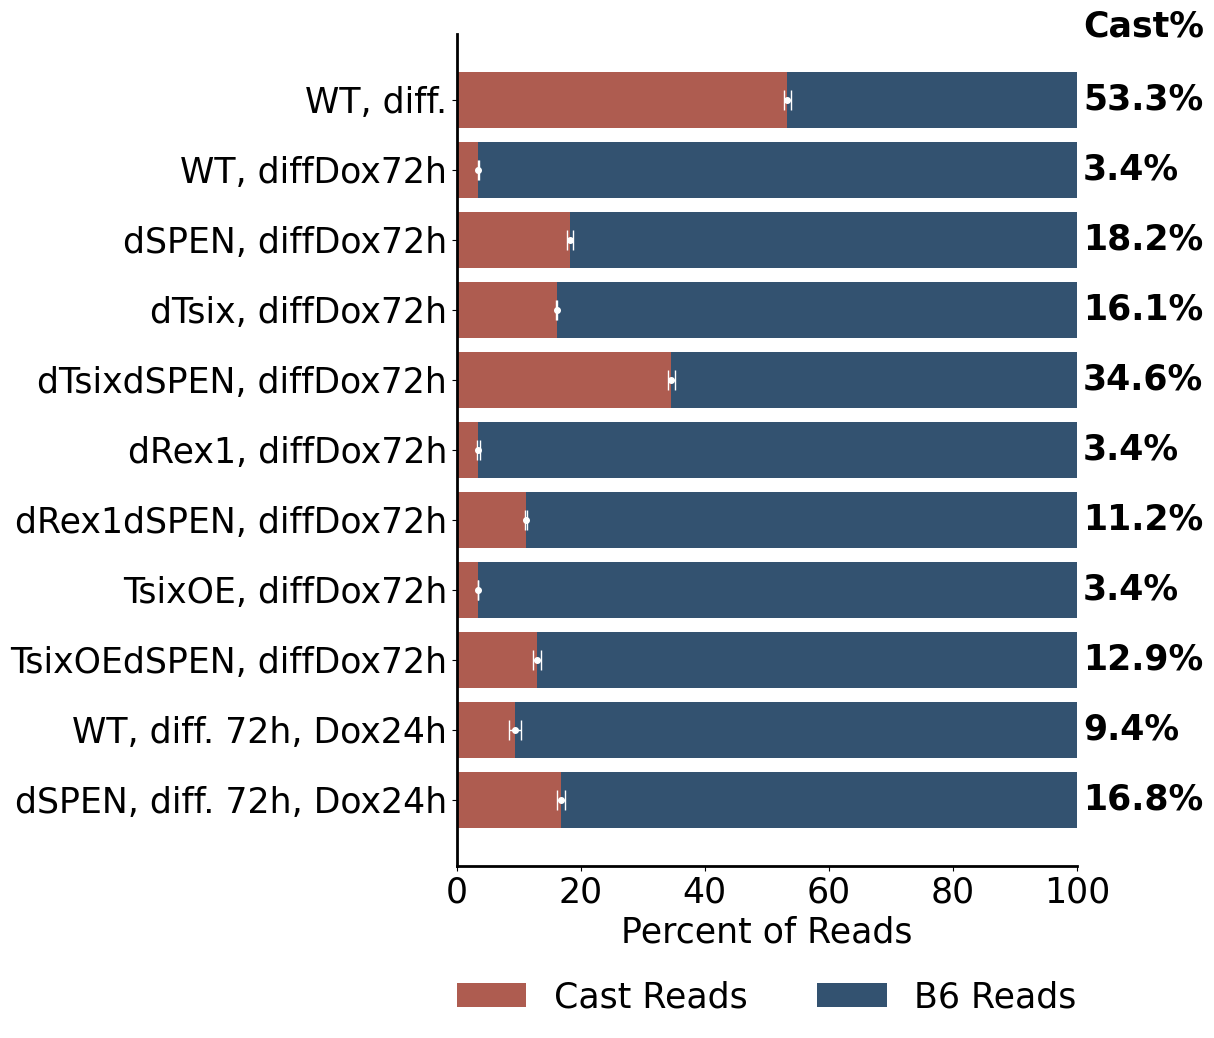

In [10]:
def plot_allele_summary_refined(
    df,
    output_dir,
    fontsize=25,
    filename="allele_spec_plot.png",
):
    if df.empty:
        return

    # Define selection and order
    sample_order = [
        "WT, diff.",
        "WT, diffDox72h",
        "dSPEN, diffDox72h",
        "dTsix, diffDox72h",
        "dTsixdSPEN, diffDox72h",
        "dRex1, diffDox72h",
        "dRex1dSPEN, diffDox72h",
        "TsixOE, diffDox72h",
        "TsixOEdSPEN, diffDox72h",
        "WT, diff. 72h, Dox24h",
        "dSPEN, diff. 72h, Dox24h",
    ]

    # Aggregate across replicates
    agg_df = (
        df.groupby("Clean_Condition")
        .agg({"Alt_percent": ["mean", "std"], "Cast_count": "sum", "B6_count": "sum"})
        .reset_index()
    )
    agg_df.columns = ["Label", "Cast_mean", "Cast_std", "Cast_total", "B6_total"]

    # Filter and sort according to user selection (bottom-up for barh order)
    agg_df = agg_df[agg_df["Label"].isin(sample_order)]
    agg_df["sort_order"] = agg_df["Label"].apply(lambda x: sample_order.index(x))
    agg_df = agg_df.sort_values("sort_order", ascending=False)

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 0.8 * len(agg_df) + 2))

    labels = agg_df["Label"].tolist()
    cast_pct = agg_df["Cast_mean"].tolist()
    b6_pct = [100 - x for x in cast_pct]
    stds = agg_df["Cast_std"].fillna(0).tolist()

    # Bars
    ax.barh(labels, cast_pct, label="Cast Reads", color="#9a3324", alpha=0.8)
    ax.barh(labels, b6_pct, left=cast_pct, label="B6 Reads", color="#00274c", alpha=0.8)

    # Error Bars (Retaining biological variance setting)
    ax.errorbar(
        cast_pct,
        labels,
        xerr=stds,
        fmt="o",
        color="white",
        markersize=4,
        capsize=7,
        elinewidth=1,
    )

    # Labels and Counts (Strict style)
    for i, (_, row) in enumerate(agg_df.iterrows()):
        # Percentage label (outside right)
        ax.text(
            101,
            i,
            f"{row.Cast_mean:.1f}%",
            va="center",
            fontweight="bold",
            fontsize=fontsize,
        )
        # # Raw count for Cast (leftmost inside)
        # ax.text(
        #     1,
        #     i,
        #     f"{int(row.Cast_total)}",
        #     va="center",
        #     ha="left",
        #     color="white",
        #     fontsize=fontsize - 7,
        # )
        # # Raw count for B6 (rightmost inside)
        # ax.text(
        #     99,
        #     i,
        #     f"{int(row.B6_total)}",
        #     va="center",
        #     ha="right",
        #     color="white",
        #     fontsize=fontsize - 7,
        # )

    # "Cast%" header
    ax.text(
        101,
        len(agg_df) - 0.2,
        "Cast%",
        va="bottom",
        fontweight="bold",
        fontsize=fontsize,
    )

    ax.set_xlabel("Percent of Reads", fontsize=fontsize)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)

    # Spines
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xlim(0, 100)

    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.1),
        ncol=2,
        frameon=False,
        fontsize=fontsize,
    )

    # plt.tight_layout()
    save_path = os.path.join(output_dir, filename)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


plot_allele_summary_refined(
    df_summary,
    PLOT_DIR,
    fontsize=FONTSIZE,
    filename="original_allele_barplot.png",
    # filename="masked_allele_barplot.png",
)

In [ ]:
def plot_snp_heatmaps(quant_dir, output_dir, fontsize=21):
    quant_files = glob.glob(os.path.join(quant_dir, "*_masked_quant.csv"))
    if not quant_files: return

    for f in sorted(quant_files):
        sample_raw = os.path.basename(f).replace("_masked_quant.csv", "")
        label = get_condition_label(sample_raw)
        rep_name = re.search(r"Rep\d+", sample_raw).group(0) if re.search(r"Rep\d+", sample_raw) else ""

        df_q = pd.read_csv(f)
        plt.figure(figsize=(6, 5))
        bins = np.arange(-0.5, 5.5, 1)
        plt.hist2d(df_q["B6_Matches"], df_q["Cast_Matches"], bins=bins, cmap="viridis", density=True, cmin=1e-7)
        cbar = plt.colorbar()
        cbar.mappable.set_clim(0, 0.85)
        cbar.set_label("Fraction of Reads", fontsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize)
        plt.xlabel("B6 SNP count per read", fontsize=fontsize)
        plt.ylabel("Cast SNP count per read", fontsize=fontsize)
        plt.title(f"{label} {rep_name}", fontsize=fontsize)
        plt.xticks(range(5), fontsize=fontsize); plt.yticks(range(5), fontsize=fontsize)
        plt.tight_layout()
        plt.show()
        plt.close()

plot_snp_heatmaps(os.path.join(RESULTS_DIR, "quantification"), PLOT_DIR)